**Importing libraries**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Analysis**
***
I have learned a lot from the previous modeling, so I merged the problematic movements, secured that the number of samples for each class is the same so the model won't learn more from one than another. I'm also doing transformation augmentation on this models.

In [11]:
# training datagen objects with transformations to apply to the dataset, as well as rescaling rggb values to 0-1 range
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True)

# Another generator, for validation images, this just resacles rgb values to 0-1 range
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

# paths to train/validation sets file folders
train_dir = 'F:Images/train/'
validation_dir = 'F:/Images/test/'

# creating train dataset fron the previous paths using the transformer
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    batch_size = 20,                                                    
                                                    target_size = (224, 224),
                                                    class_mode='categorical',
                                                   )
# creating validation set using the same method
validation_generator = validation_datagen.flow_from_directory(directory = validation_dir, 
                                                        batch_size = 20, 
                                                        class_mode = 'categorical', 
                                                        target_size = (224, 224))

Found 18670 images belonging to 12 classes.
Found 4800 images belonging to 12 classes.


In [4]:
# creating a variable that has the number of classes, will be important to define the output layer
# nodes of our model
n_classes = len(train_generator.class_indices)

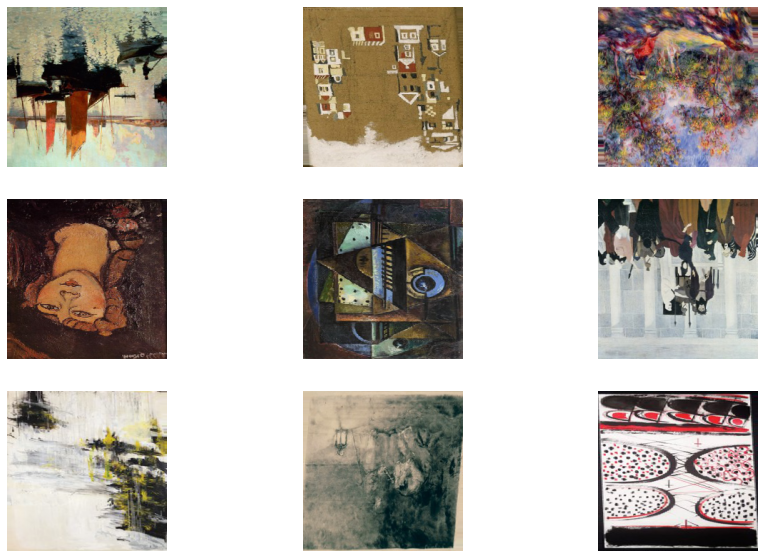

In [5]:
# ploting a few images just to see the dataset
plt.figure(figsize=(15, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    r = random.randint(0, len(train_generator))
    plt.imshow(train_generator.__getitem__(r)[0][1])

    plt.axis("off")


**Model creation**
***
In next cells we will create our model based on a resnet architecture, we will use the learning rate of the previous base model, in this case we will retrain all the network weights.

In [6]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [7]:
for layer in base_model.layers:
    layer.trainable = True

In [8]:
# Add layers at the end of the resnet base structure
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [9]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

**Parameter definition**
***
Defining the number of epochs to calculate, also early stops and an object to reduce the learning rate in the loss begins to increase. patience values are there so the evaluation won't be based on spikes of loss, because it naturraly happens.

In [11]:
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')



In [12]:
# Train the model - all layers
history1 = model.fit(train_generator, 
                     validation_data=validation_generator,
                     epochs=n_epoch,
                     shuffle=True,
                     verbose=1,
                     callbacks=[reduce_lr]
                     )

Epoch 1/30
934/934 [==============================] - 196s 200ms/step - loss: 1.9425 - accuracy: 0.3821 - val_loss: 1.9398 - val_accuracy: 0.3827 - lr: 1.0000e-04
Epoch 2/30
934/934 [==============================] - 184s 197ms/step - loss: 1.6169 - accuracy: 0.5372 - val_loss: 1.5729 - val_accuracy: 0.5202 - lr: 1.0000e-04
Epoch 3/30
934/934 [==============================] - 185s 198ms/step - loss: 1.4099 - accuracy: 0.5945 - val_loss: 1.4705 - val_accuracy: 0.5479 - lr: 1.0000e-04
Epoch 4/30
934/934 [==============================] - 190s 203ms/step - loss: 1.2418 - accuracy: 0.6355 - val_loss: 1.3630 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 5/30
934/934 [==============================] - 191s 204ms/step - loss: 1.1055 - accuracy: 0.6717 - val_loss: 1.4777 - val_accuracy: 0.5194 - lr: 1.0000e-04
Epoch 6/30
934/934 [==============================] - 190s 204ms/step - loss: 0.9764 - accuracy: 0.7073 - val_loss: 1.3277 - val_accuracy: 0.5756 - lr: 1.0000e-04
Epoch 7/30
934/934 [==

**Analysis RESnet50**
***
Our performance looks amazing, almost 70%. For art movements this is really good because it's classifying something much more complex than shapes. I'm saving the model for further usage and ploting the the loss and learning rate. This model could probably be improved with more epochs, but due to time restrictions i can't compute them, so this for now is my best model.

In [13]:
model.save('RasNet50_v3_f.h5')

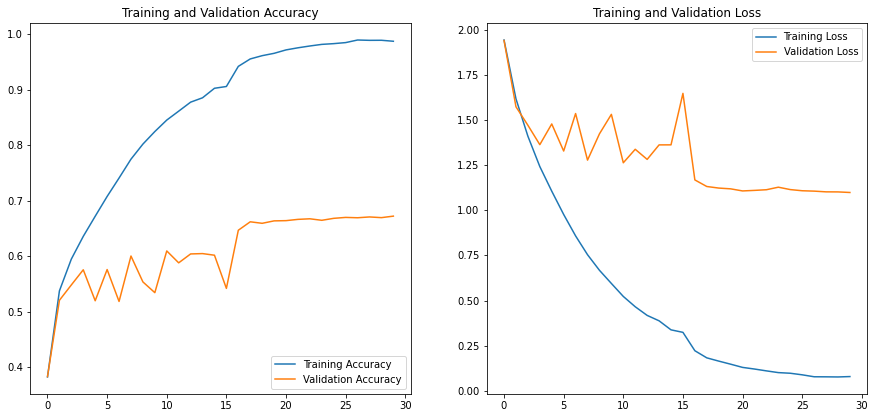

In [15]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Creating a model using VGG19**
***
The same as creating a model with resnet, but trying this one since from what i've read is even better than resnet.

In [18]:
base_model_2 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [20]:
X = base_model_2.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output_2 = Dense(n_classes, activation='softmax')(X)

model_2 = Model(inputs=base_model_2.input, outputs=output_2)

for layer in model.layers:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 35

history2 = model_2.fit(train_generator, 
                     validation_data=validation_generator,
                     epochs=n_epoch,
                     shuffle=True,
                     verbose=1,
                     callbacks=[reduce_lr]
                     )

C:\Users\VideoMachine\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/35
934/934 [==============================] - 231s 242ms/step - loss: 2.3522 - accuracy: 0.1675 - val_loss: 3.2235 - val_accuracy: 0.0910 - lr: 1.0000e-04
Epoch 2/35
934/934 [==============================] - 226s 242ms/step - loss: 2.1774 - accuracy: 0.2472 - val_loss: 3.2472 - val_accuracy: 0.1517 - lr: 1.0000e-04
Epoch 3/35
934/934 [==============================] - 225s 241ms/step - loss: 2.0705 - accuracy: 0.2909 - val_loss: 2.6106 - val_accuracy: 0.1562 - lr: 1.0000e-04
Epoch 4/35
934/934 [==============================] - 225s 241ms/step - loss: 1.9792 - accuracy: 0.3246 - val_loss: 1.9528 - val_accuracy: 0.3377 - lr: 1.0000e-04
Epoch 5/35
934/934 [==============================] - 215s 230ms/step - loss: 1.9148 - accuracy: 0.3446 - val_loss: 1.9512 - val_accuracy: 0.3423 - lr: 1.0000e-04
Epoch 6/35
934/934 [==============================] - 201s 215ms/step - loss: 1.8476 - accuracy: 0.3698 - val_loss: 1.8113 - val_accuracy: 0.3790 - lr: 1.0000e-04
Epoch 7/35
934/934 [==

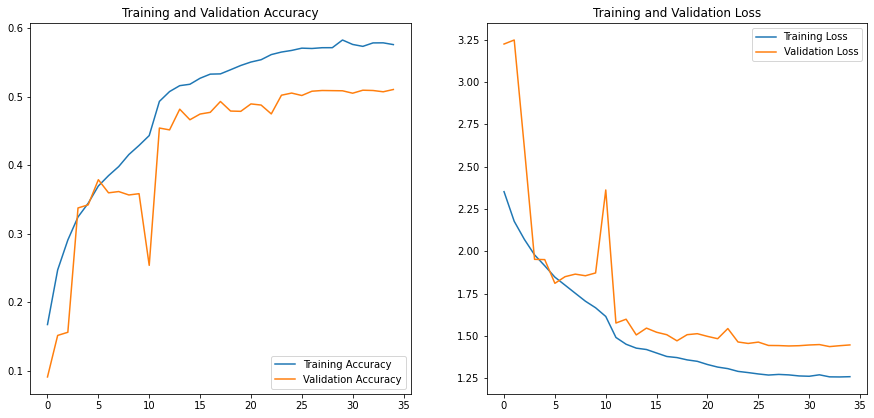

In [21]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(35)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
model_2.save('VGG19_v1.h5')

**Analysis VGG19**
***
Not the best performer, maybe has to be more finelly tunned. that said i'm happy with resnet, so i'll keep that one, and probably in the future train it with more epochs to try improving it.